<a href="https://colab.research.google.com/github/DFazekas/thesis_analysis/blob/main/Thesis_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

# Import data
First, important the data and ensure all columns have equal non-null rows.

In [103]:
df = pd.read_csv("data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Demand         270 non-null    object 
 1   Penetration    270 non-null    object 
 2   Travel Time    270 non-null    int64  
 3   Run            270 non-null    int64  
 4   Waiting Time   270 non-null    int64  
 5   Time Loss      270 non-null    float64
 6   Waiting Count  270 non-null    int64  
 7   Average Speed  270 non-null    float64
 8   Crossing       270 non-null    int64  
 9   Following      270 non-null    int64  
 10  Merging        270 non-null    int64  
 11  RTT            270 non-null    int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 25.4+ KB


<Figure size 432x288 with 0 Axes>

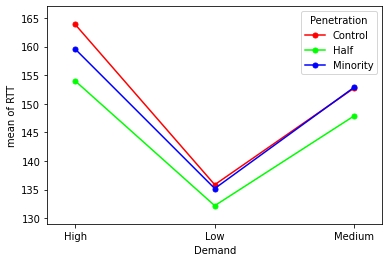

In [104]:
plt.clf()
fig = interaction_plot(df['Demand'], df['Penetration'], df['RTT'], ms=10)

<Figure size 432x288 with 0 Axes>

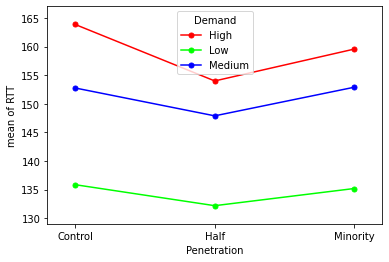

In [105]:
plt.clf()
fig = interaction_plot(df['Penetration'], df['Demand'], df['RTT'], ms=10)

# Testing ANOVA Assumptions
Before we perform a Brown-Forsythe test, we can calculate the variance of the plant measurements in each group.

In [106]:
group_control = df[df['Penetration'] == 'Control']['RTT']
group_minority = df[df['Penetration'] == 'Minority']['RTT']
group_half = df[df['Penetration'] == 'Half']['RTT']

print(f"Control variance: {np.var(group_control)}")
print(f"Minority variance: {np.var(group_minority)}")
print(f"Half variance: {np.var(group_half)}")

Control variance: 221.2277777777778
Minority variance: 227.9506172839506
Half variance: 174.16555555555556


We can see that the variances between the groups differ, but to determine if these differences are statistically significant we can perform the Brown-Forsythe test.

If we fail to reject the null hypothesis of the Brown-Forsythe Test, then we can proceed to perform a one-way ANOVA on the data.

In [107]:
stats.levene(group_control, group_minority, group_half, center='median')

LeveneResult(statistic=1.8046154775204561, pvalue=0.16653876880143142)

The p-value of the test turns out to be greater than .05, so we fail to reject the null hypothesis of the test. The differences in the variances between the groups is not statistically significant. Therefore, we can proceed with ANOVA.

# Two-way ANOVA test
Use a two-way ANOVA test to see if the means between groups are statistically different. This is achieved by reviewing the p-value in the ANOVA results; p-values < 0.05 are statistically significant.

In [108]:
model = ols('RTT ~ Demand + Penetration + Demand*Penetration', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
Demand,28668.007407,2.0,138.210537,1.162837e-41
Penetration,1819.918519,2.0,8.773959,2.051857e-04
Demand:Penetration,364.281481,4.0,0.878114,4.775200e-01
Residual,27068.666667,261.0,NaN,NaN


From the above graph, both factors can be seen to have p-values below 0.05. This implies that the variances in the factors can be explained by the different treatments. However, the interaction between the factors has a p-value > 0.05, thus, they do not interaction.

But this does not tell us where they're the differences are within the factors. For that, a post hoc test is required.

When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey’s HSD test).

In [109]:
print(model.tvalues)
# print(model.summary())
# fig = sm.graphics.plot_regress_exog(model, 'Penetration')

Intercept                                   88.132902
Demand[T.Low]                              -10.648550
Demand[T.Medium]                            -4.221390
Penetration[T.Half]                         -3.752346
Penetration[T.Minority]                     -1.635313
Demand[T.Low]:Penetration[T.Half]            1.667282
Demand[T.Medium]:Penetration[T.Half]         1.344583
Demand[T.Low]:Penetration[T.Minority]        0.977063
Demand[T.Medium]:Penetration[T.Minority]     1.192196
dtype: float64


Text(0, 0.5, 'Frequency')

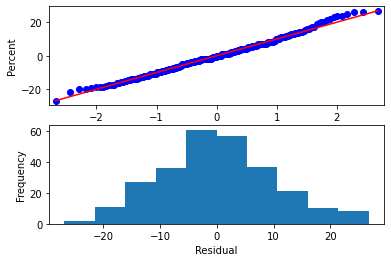

In [110]:
res = model.resid 

fig, axes = plt.subplots(2)
graph1 = sm.qqplot(res, line='s', xlabel="Residual", ylabel="Percent", ax=axes[0])

graph2 = plt.hist(res, axes=axes[1])
plt.xlabel("Residual")
plt.ylabel("Frequency")

Q-Q plots are used to find the type of distribution for a random variable. You can tell the type of distribution using the power of the Q-Q plot just by looking at the plot. From the abova Q-Q plot, we can conclude the residuals of the ANOVA test are indeed normally distributed. This is further supported by the histogram plot.

# Post Hoc Tests

Given our 3 levels of penetration [Control, Minority, Half], there are 3 possible pair-wise combinations:
1. Control x Minority
2. Minority x Half
3. Control x Half

With only 3 comparisons and a 5% confidence interval, our **family-wise error rate** is 0.1426, computed by: $$1-(1-\alpha )^\text{comparisons}$$

In [111]:
pair_t = model.t_test_pairwise('Penetration')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Half-Control,-9.866667,2.629466,-3.752346,0.000216,-15.044334,-4.688999,0.000648,True
Minority-Control,-4.300000,2.629466,-1.635313,0.103189,-9.477667,0.877667,0.103189,False
Minority-Half,5.566667,2.629466,2.117033,0.035203,0.388999,10.744334,0.069167,False


From the table above, we see that only the Half-Control pairwise comparison for treatments rejects the null hypothesis (p < 0.05) and indiciates statistical significant differences.

